In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, load_img
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add

In [2]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions  = readTextFile("./Datasets/Image_captioninng_data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [5]:
print(len(captions))

40460


In [21]:
first,second  = captions[110].split('\t')
print(first.split('.')[0])
print(second)

1026685415_0431cbf574
A black dog carries a green toy in his mouth as he walks through the grass .


In [9]:
# Dictionary to Map each Image with the list of captions it has
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [22]:
descriptions["1026685415_0431cbf574"]

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

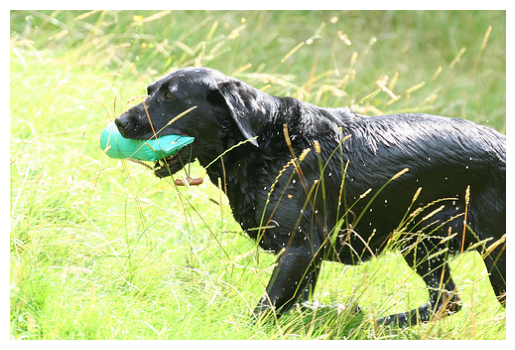

In [23]:
IMG_PATH = "./Datasets/Image_captioninng_data/Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1026685415_0431cbf574.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

data cleaning

In [25]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [w for w in sentence if len(w)>1]
    sentence = " ".join(sentence)
    return sentence

In [26]:
sent1 = "A cat is sitting over the house # 64"

In [28]:
clean_text(sent1)

'cat is sitting over the house'

In [34]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [36]:
descriptions["1026685415_0431cbf574"]

['black dog carries green toy in his mouth as he walks through the grass',
 'black dog carrying something through the grass',
 'black dog has blue toy in its mouth',
 'dog in grass with blue item in his mouth',
 'wet black dog is carrying green toy through the grass']

In [38]:
# Write the data to text file
with open("descriptions_cleaned_1.txt","w") as f:
    f.write(str(descriptions))

VOCAB

In [40]:
descriptions = None
with open("descriptions_cleaned_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [42]:
type(descriptions)

dict

In [43]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [44]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


### Filter Words from the Vocab according to certain threshold frequncy

In [49]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
#print(counter)
#print(freq_cnt)
print(len(freq_cnt.keys()))
print(len(vocab))

8424
8424


In [50]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [51]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [52]:
train_file_data = readTextFile("Datasets/Image_captioninng_data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Datasets/Image_captioninng_data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [53]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [58]:
train[:10]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

In [57]:
# Prepare Description for the Training Data
# Tweak - Add <s> = 'startseq ' and <e> = ' endseq' token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        modified_cap = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(modified_cap)

In [60]:
train_descriptions['2513260012_03d33305cf']

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [61]:
descriptions['2513260012_03d33305cf']

['black dog is running after white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through low lying body of water']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [63]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [64]:
model_new = Model(model.input,model.layers[-2].output)

In [77]:
def preprocess_img(img):
    img = keras.utils.load_img(img,target_size=(224,224))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


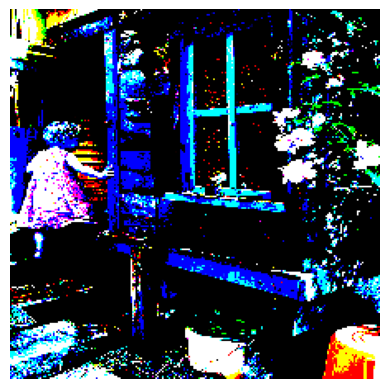

In [78]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [81]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    print(feature_vector.shape)
    return feature_vector

In [84]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 0s 77ms/step
(2048,)


array([0.06536551, 0.16782704, 0.32518464, ..., 0.05111536, 0.3281792 ,
       1.0043334 ], dtype=float32)

In [91]:
for ix,im_id in enumerate(train):
    print(ix,im_id)

0 2513260012_03d33305cf
1 2903617548_d3e38d7f88
2 3338291921_fe7ae0c8f8
3 488416045_1c6d903fe0
4 2644326817_8f45080b87
5 218342358_1755a9cce1
6 2501968935_02f2cd8079
7 2699342860_5288e203ea
8 2638369467_8fc251595b
9 2926786902_815a99a154
10 2851304910_b5721199bc
11 3423802527_94bd2b23b0
12 3356369156_074750c6cc
13 2294598473_40637b5c04
14 1191338263_a4fa073154
15 2380765956_6313d8cae3
16 3197891333_b1b0fd1702
17 3119887967_271a097464
18 2276499757_b44dc6f8ce
19 2506892928_7e79bec613
20 2187222896_c206d63396
21 2826769554_85c90864c9
22 3097196395_ec06075389
23 3603116579_4a28a932e2
24 3339263085_6db9fd0981
25 2532262109_87429a2cae
26 2076906555_c20dc082db
27 2502007071_82a8c639cf
28 3113769557_9edbb8275c
29 3325974730_3ee192e4ff
30 1655781989_b15ab4cbff
31 1662261486_db967930de
32 2410562803_56ec09f41c
33 2469498117_b4543e1460
34 69710415_5c2bfb1058
35 3414734842_beb543f400
36 3006217970_90b42e6b27
37 2192411521_9c7e488c5e
38 3535879138_9281dc83d5
39 2685788323_ceab14534a
40 3465606652_

In [85]:
start_t = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start_t)

1/1 [==============================] - 0s 80ms/step
(2048,)
Encoding in Progress Time step 0 
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 106ms/step
(2048,)
1/1 [==============================] - 0s 99ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [

1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 108ms/step
(2048,)
1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 124ms/step
(2048,)
1/1 [==============================] - 0s 122ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 112ms/step
(2048,)
1/1 [==============================] - 0s 123ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 116ms/step
(2048,)
1/1 [==============================] - 0s 96ms/step
(2048,)
1/1 [==============================] - 0s 103ms/step
(2048,)
1/1 [=========================

1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 127ms/step
(2048,)
1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 144ms/step
(2048,)
1/1 [==============================] - 0s 142ms/step
(2048,)
1/1 [==============================] - 0s 133ms/step
(2048,)
1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [==============================] - 0s 126ms/step
(2048,)
1/1 [==============================] - 0s 106ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 123ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [=========================

1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 102ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 

1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 104ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 

(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [===========================

1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 125ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 

1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 110ms/step
(2048,)
1/1 [==============================] - 0s 138ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
Encoding in Progress Time step 1500 
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1

1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 103ms/step
(2048,)
1/1 [==============================] - 0s 99ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 101ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] -

1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
Encoding in Progress Time step 1900 
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1

1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 95ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
Encoding in Progress Time step 2300 
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1

1/1 [==============================] - 0s 162ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 108ms/step
(2048,)
1/1 [==============================] - 0s 101ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [=============================

1/1 [==============================] - 0s 95ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 87ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 86ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0

(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 96ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 95ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 137ms/step
(2048,)
1/1 [==============================] - 0s 111ms/step
(2048,)
1/1 [==============================] - 0s 106ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 100ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 95ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [=======================

1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 106ms/step
(2048,)
1/1 [==============================] - 0s 107ms/step
(2048,)
1/1 [==============================] - 0s 96ms/step
(2048,)
1/1 [==============================] - 0s 95ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 101ms/step
(2048,)
1/1 [==============================] - 0s 102ms/step
(2048,)
1/1 [==============================] - 0s 104ms/step
(2048,)
1/1 [==============================] - 0s 100ms/step
(2048,)
1/1 [==============================] - 0s 105ms/step
(2048,)
1/1 [==============================] - 0s 101ms/step
(2048,)
1/1 [==============================] - 0s 103ms/step
(2048,)
1/1 [==============================] - 0s 105ms/step
(2048,)
1/1 [==============================] - 0s 105ms/step
(2048,)
1/1 [==============================] - 0s 105ms/step
(2048,)
1/1 [======================

1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 126ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 132ms/step
(2048,)
1/1 [==============================] - 0s 134ms/step
(2048,)
1/1 [==============================] - 0s 136ms/step
(2048,)
1/1 [==============================] - 0s 135ms/step
(2048,)
1/1 [==============================] - 0s 182ms/step
(2048,)
1/1 [==============================] - 0s 197ms/step
(2048,)
1/1 [==============================] - 0s 205ms/step
(2048,)
1/1 [==============================] - 0s 196ms/step
(2048,)
1/1 [==============================] - 0s 154ms/step
(2048,)
1/1 [==============================] - 0s 131ms/step
(2048,)
1/1 [==============================] - 0s 132ms/step
(2048,)
1/1 [==============================] - 0s 163ms/step
(2048,)
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 141ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 134ms/step
(2048,)
1/1 [==============================] - 0s 134ms/step
(2048,)
1/1 [==============================] - 0s 136ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 137ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 142ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 144ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [==============================] - 0s 142ms/step
(2048,)
1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 150ms/step
(2048,)
1/1 [==============================] - 0s 156ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 150ms/step
(2048,)
1/1 [==============================] - 0s 151ms/step
(2048,)
1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 151ms/step
(2048,)
1/1 [==============================] - 0s 141ms/step
(2048,)
1/1 [==============================] - 0s 145ms/step
(2048,)
1/1 [==============================] - 0s 151ms/step
(2048,)
1/1 [==============================] - 0s 154ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 153ms/step
(2048,)
1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 162ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 219ms/step
(2048,)
1/1 [==============================] - 0s 197ms/step
(2048,)
1/1 [==============================] - 0s 165ms/step
(2048,)
1/1 [==============================] - 0s 166ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 156ms/step
(2048,)
1/1 [==============================] - 0s 150ms/step
(2048,)
1/1 [==============================] - 0s 159ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 158ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 170ms/step
(2048,)
1/1 [==============================] - 0s 171ms/step
(2048,)
1/1 [==============================] - 0s 165ms/step
(2048,)
1/1 [==============================] - 0s 164ms/step
(2048,)
1/1 [==============================] - 0s 170ms/step
(2048,)
1/1 [==============================] - 0s 173ms/step
(2048,)
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 168ms/step
(2048,)
1/1 [==============================] - 0s 170ms/step
(2048,)
1/1 [==============================] - 0s 172ms/step
(2048,)
1/1 [==============================] - 0s 172ms/step
(2048,)
1/1 [==============================] - 0s 172ms/step
(2048,)
1/1 [==============================] - 0s 166ms/step
(2048,)
1/1 [==============================] - 0s 164ms/step
(2048,)
1/1 [==============================] - 0s 171ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 162ms/step
(2048,)
1/1 [==============================] - 0s 168ms/step
(2048,)
1/1 [==============================] - 0s 166ms/step
(2048,)
1/1 [==============================] - 0s 168ms/step
(2048,)
1/1 [==============================] - 0s 170ms/step
(2048,)
1/1 [==============================] - 0s 167ms/step
(2048,)
1/1 [==============================] - 0s 167ms/step
(2048,)
1/1 [==============================] - 0s 167ms/step
(2048,)
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 167ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 164ms/step
(2048,)
1/1 [==============================] - 0s 168ms/step
(2048,)
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 167ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 180ms/step
(2048,)
1/1 [==============================] - 0s 181ms/step
(2048,)
1/1 [==============================] - 0s 182ms/step
(2048,)
1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 186ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 238ms/step
(2048,)
1/1 [==============================] - 0s 187ms/step
(2048,)
1/1 [==============================] - 0s 178ms/step
(2048,)
1/1 [==============================] - 0s 178ms/step
(2048,)
1/1 [==============================] - 0s 180ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 215ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [==============================] - 0s 179ms/step
(2048,)
1/1 [==============================] - 0s 180ms/step
(2048,)
1/1 [==============================] - 0s 234ms/step
(2048,)
1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 179ms/step
(2048,)
1/1 [==============================] - 0s 178ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 186ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 188ms/step
(2048,)
1/1 [==============================] - 0s 187ms/step
(2048,)
1/1 [==============================] - 0s 188ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 182ms/step
(2048,)
1/1 [==============================] - 0s 187ms/step
(2048,)
1/1 [==============================] - 0s 189ms/step
(2048,)
1/1 [==============================] - 0s 189ms/step
(2048,)
1/1 [==============================] - 0s 187ms/step
(2048,)
1/1 [==============================] - 0s 187ms/step
(2048,)
1/1 [==============================] - 0s 190ms/step
(2048,)
1/1 [==============================] - 0s 188ms/step
(2048,)
1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 205ms/step
(2048,)
1/1 [==============================] - 0s 212ms/step
(2048,)
1/1 [==============================] - 0s 213ms/step
(2048,)
1/1 [==============================] - 0s 216ms/step
(2048,)
1/1 [==============================] - 0s 212ms/step
(2048,)
1/1 [==============================] - 0s 213ms/step
(2048,)
1/1 [==============================] - 0s 213ms/step
(2048,)
1/1 [==============================] - 0s 212ms/step
(2048,)
1/1 [==============================] - 0s 202ms/step
(2048,)
1/1 [==============================] - 0s 210ms/step
(2048,)
1/1 [==============================] - 0s 213ms/step
(2048,)
1/1 [==============================] - 0s 208ms/step
(2048,)
1/1 [==============================] - 0s 210ms/step
(2048,)
1/1 [==============================] - 0s 215ms/step
(2048,)
1/1 [==============================] - 0s 218ms/step
(2048,)
1/1 [==============================] - 0s 215ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 224ms/step
(2048,)
1/1 [==============================] - 0s 222ms/step
(2048,)
1/1 [==============================] - 0s 224ms/step
(2048,)
1/1 [==============================] - 0s 219ms/step
(2048,)
1/1 [==============================] - 0s 213ms/step
(2048,)
1/1 [==============================] - 0s 222ms/step
(2048,)
1/1 [==============================] - 0s 222ms/step
(2048,)
1/1 [==============================] - 0s 223ms/step
(2048,)
1/1 [==============================] - 0s 220ms/step
(2048,)
1/1 [==============================] - 0s 222ms/step
(2048,)
1/1 [==============================] - 0s 226ms/step
(2048,)
1/1 [==============================] - 0s 220ms/step
(2048,)
1/1 [==============================] - 0s 213ms/step
(2048,)
1/1 [==============================] - 0s 222ms/step
(2048,)
1/1 [==============================] - 0s 221ms/step
(2048,)
1/1 [==============================] - 0s 222ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 227ms/step
(2048,)
1/1 [==============================] - 0s 231ms/step
(2048,)
1/1 [==============================] - 0s 229ms/step
(2048,)
1/1 [==============================] - 0s 232ms/step
(2048,)
1/1 [==============================] - 0s 234ms/step
(2048,)
1/1 [==============================] - 0s 231ms/step
(2048,)
1/1 [==============================] - 0s 224ms/step
(2048,)
1/1 [==============================] - 0s 233ms/step
(2048,)
1/1 [==============================] - 0s 227ms/step
(2048,)
1/1 [==============================] - 0s 226ms/step
(2048,)
1/1 [==============================] - 0s 228ms/step
(2048,)
1/1 [==============================] - 0s 227ms/step
(2048,)
1/1 [==============================] - 0s 230ms/step
(2048,)
1/1 [==============================] - 0s 232ms/step
(2048,)
1/1 [==============================] - 0s 223ms/step
(2048,)
1/1 [==============================] - 0s 232ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 241ms/step
(2048,)
1/1 [==============================] - 0s 239ms/step
(2048,)
1/1 [==============================] - 0s 238ms/step
(2048,)
1/1 [==============================] - 0s 246ms/step
(2048,)
1/1 [==============================] - 0s 239ms/step
(2048,)
1/1 [==============================] - 0s 239ms/step
(2048,)
1/1 [==============================] - 0s 244ms/step
(2048,)
1/1 [==============================] - 0s 241ms/step
(2048,)
1/1 [==============================] - 0s 236ms/step
(2048,)
1/1 [==============================] - 0s 231ms/step
(2048,)
1/1 [==============================] - 0s 242ms/step
(2048,)
1/1 [==============================] - 0s 248ms/step
(2048,)
1/1 [==============================] - 0s 244ms/step
(2048,)
1/1 [==============================] - 0s 242ms/step
(2048,)
1/1 [==============================] - 0s 243ms/step
(2048,)
1/1 [==============================] - 0s 245ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 255ms/step
(2048,)
1/1 [==============================] - 0s 254ms/step
(2048,)
1/1 [==============================] - 0s 244ms/step
(2048,)
1/1 [==============================] - 0s 253ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [==============================] - 0s 330ms/step
(2048,)
1/1 [==============================] - 0s 256ms/step
(2048,)
1/1 [==============================] - 0s 259ms/step
(2048,)
1/1 [==============================] - 0s 250ms/step
(2048,)
1/1 [==============================] - 0s 250ms/step
(2048,)
1/1 [==============================] - 0s 255ms/step
(2048,)
1/1 [==============================] - 0s 254ms/step
(2048,)
1/1 [==============================] - 0s 261ms/step
(2048,)
1/1 [==============================] - 0s 264ms/step
(2048,)
1/1 [==============================] - 0s 259ms/step
(2048,)
1/1 [==============================] - 0s 254ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 250ms/step
(2048,)
1/1 [==============================] - 0s 259ms/step
(2048,)
1/1 [==============================] - 0s 258ms/step
(2048,)
1/1 [==============================] - 0s 262ms/step
(2048,)
1/1 [==============================] - 0s 262ms/step
(2048,)
1/1 [==============================] - 0s 265ms/step
(2048,)
1/1 [==============================] - 0s 259ms/step
(2048,)
1/1 [==============================] - 0s 255ms/step
(2048,)
1/1 [==============================] - 0s 263ms/step
(2048,)
1/1 [==============================] - 0s 258ms/step
(2048,)
1/1 [==============================] - 0s 260ms/step
(2048,)
1/1 [==============================] - 0s 266ms/step
(2048,)
1/1 [==============================] - 0s 258ms/step
(2048,)
1/1 [==============================] - 0s 255ms/step
(2048,)
1/1 [==============================] - 0s 250ms/step
(2048,)
1/1 [==============================] - 0s 262ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 271ms/step
(2048,)
Encoding in Progress Time step 5100 
1/1 [==============================] - 0s 266ms/step
(2048,)
1/1 [==============================] - 0s 267ms/step
(2048,)
1/1 [==============================] - 0s 270ms/step
(2048,)
1/1 [==============================] - 0s 268ms/step
(2048,)
1/1 [==============================] - 0s 322ms/step
(2048,)
1/1 [==============================] - 0s 355ms/step
(2048,)
1/1 [==============================] - 0s 328ms/step
(2048,)
1/1 [==============================] - 0s 317ms/step
(2048,)
1/1 [==============================] - 0s 288ms/step
(2048,)
1/1 [==============================] - 0s 263ms/step
(2048,)
1/1 [==============================] - 0s 267ms/step
(2048,)
1/1 [==============================] - 0s 270ms/step
(2048,)
1/1 [==============================] - 0s 278ms/step
(2048,)
1/1 [==============================] - 0s 285ms/step
(2048,)
1/1 [==============================] - 0s 301ms/

1/1 [==============================] - 0s 276ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [==============================] - 0s 270ms/step
(2048,)
1/1 [==============================] - 0s 277ms/step
(2048,)
1/1 [==============================] - 0s 278ms/step
(2048,)
1/1 [==============================] - 0s 279ms/step
(2048,)
1/1 [==============================] - 0s 279ms/step
(2048,)
1/1 [==============================] - 0s 276ms/step
(2048,)
1/1 [==============================] - 0s 276ms/step
(2048,)
1/1 [==============================] - 0s 273ms/step
(2048,)
1/1 [==============================] - 0s 285ms/step
(2048,)
1/1 [==============================] - 0s 278ms/step
(2048,)
1/1 [==============================] - 0s 277ms/step
(2048,)
1/1 [==============================] - 0s 276ms/step
(2048,)
1/1 [==============================] - 0s 284ms/step
(2048,)
1/1 [==============================] - 0s 276ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 253ms/step
(2048,)
1/1 [==============================] - 0s 250ms/step
(2048,)
1/1 [==============================] - 0s 244ms/step
(2048,)
1/1 [==============================] - 0s 252ms/step
(2048,)
1/1 [==============================] - 0s 253ms/step
(2048,)
1/1 [==============================] - 0s 252ms/step
(2048,)
1/1 [==============================] - 0s 252ms/step
(2048,)
1/1 [==============================] - 0s 253ms/step
(2048,)
1/1 [==============================] - 0s 253ms/step
(2048,)
1/1 [==============================] - 0s 245ms/step
(2048,)
1/1 [==============================] - 0s 251ms/step
(2048,)
1/1 [==============================] - 0s 251ms/step
(2048,)
1/1 [==============================] - 0s 252ms/step
(2048,)
1/1 [==============================] - 0s 253ms/step
(2048,)
1/1 [==============================] - 0s 252ms/step
(2048,)
1/1 [==============================] - 0s 251ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 258ms/step
(2048,)
1/1 [==============================] - 0s 260ms/step
(2048,)
Encoding in Progress Time step 5500 
1/1 [==============================] - 0s 261ms/step
(2048,)
1/1 [==============================] - 0s 266ms/step
(2048,)
1/1 [==============================] - 0s 269ms/step
(2048,)
1/1 [==============================] - 0s 268ms/step
(2048,)
1/1 [==============================] - 0s 269ms/step
(2048,)
1/1 [==============================] - 0s 282ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [==============================] - 0s 279ms/step
(2048,)
1/1 [==============================] - 0s 272ms/step
(2048,)
1/1 [==============================] - 0s 269ms/step
(2048,)
1/1 [==============================] - 0s 277ms/step
(2048,)
1/1 [==============================] - 0s 279ms/

1/1 [==============================] - 0s 273ms/step
(2048,)
1/1 [==============================] - 0s 268ms/step
(2048,)
1/1 [==============================] - 0s 276ms/step
(2048,)
1/1 [==============================] - 0s 277ms/step
(2048,)
1/1 [==============================] - 0s 274ms/step
(2048,)
1/1 [==============================] - 0s 273ms/step
(2048,)
1/1 [==============================] - 0s 281ms/step
(2048,)
1/1 [==============================] - 0s 273ms/step
(2048,)
1/1 [==============================] - 0s 266ms/step
(2048,)
1/1 [==============================] - 0s 281ms/step
(2048,)
1/1 [==============================] - 0s 275ms/step
(2048,)
1/1 [==============================] - 0s 282ms/step
(2048,)
1/1 [==============================] - 0s 277ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [==============================] - 0s 279ms/step
(2048,)
1/1 [==============================] - 0s 280ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 290ms/step
(2048,)
1/1 [==============================] - 0s 296ms/step
(2048,)
1/1 [==============================] - 0s 298ms/step
(2048,)
1/1 [==============================] - 0s 299ms/step
(2048,)
1/1 [==============================] - 0s 293ms/step
(2048,)
1/1 [==============================] - 0s 289ms/step
(2048,)
1/1 [==============================] - 0s 294ms/step
(2048,)
1/1 [==============================] - 0s 292ms/step
(2048,)
1/1 [==============================] - 0s 288ms/step
(2048,)
1/1 [==============================] - 0s 291ms/step
(2048,)
1/1 [==============================] - 0s 286ms/step
(2048,)
1/1 [==============================] - 0s 279ms/step
(2048,)
1/1 [==============================] - 0s 288ms/step
(2048,)
1/1 [==============================] - 0s 290ms/step
(2048,)
1/1 [==============================] - 0s 286ms/step
(2048,)
1/1 [==============================] - 0s 287ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 301ms/step
(2048,)
1/1 [==============================] - 0s 303ms/step
(2048,)
1/1 [==============================] - 0s 292ms/step
(2048,)
Encoding in Progress Time step 5900 
1/1 [==============================] - 0s 306ms/step
(2048,)
1/1 [==============================] - 0s 298ms/step
(2048,)
1/1 [==============================] - 0s 298ms/step
(2048,)
1/1 [==============================] - 0s 302ms/step
(2048,)
1/1 [==============================] - 0s 302ms/step
(2048,)
1/1 [==============================] - 0s 296ms/step
(2048,)
1/1 [==============================] - 0s 303ms/step
(2048,)
1/1 [==============================] - 0s 302ms/step
(2048,)
1/1 [==============================] - 0s 304ms/step
(2048,)
1/1 [==============================] - 0s 303ms/step
(2048,)
1/1 [==============================] - 0s 303ms/step
(2048,)
1/1 [==============================] - 0s 296ms/step
(2048,)
1/1 [==============================] - 0s 306ms/

In [92]:
!mkdir saved

In [93]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [94]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

1/1 [==============================] - 0s 315ms/step
(2048,)
Test Encoding in Progress Time step 0 
1/1 [==============================] - 0s 318ms/step
(2048,)
1/1 [==============================] - 0s 315ms/step
(2048,)
1/1 [==============================] - 0s 318ms/step
(2048,)
1/1 [==============================] - 0s 321ms/step
(2048,)
1/1 [==============================] - 0s 338ms/step
(2048,)
1/1 [==============================] - 0s 316ms/step
(2048,)
1/1 [==============================] - 0s 312ms/step
(2048,)
1/1 [==============================] - 0s 317ms/step
(2048,)
1/1 [==============================] - 0s 312ms/step
(2048,)
1/1 [==============================] - 0s 314ms/step
(2048,)
1/1 [==============================] - 0s 296ms/step
(2048,)
1/1 [==============================] - 0s 304ms/step
(2048,)
1/1 [==============================] - 0s 308ms/step
(2048,)
1/1 [==============================] - 0s 341ms/step
(2048,)
1/1 [==============================] - 0s 346m

1/1 [==============================] - 0s 319ms/step
(2048,)
1/1 [==============================] - 0s 321ms/step
(2048,)
1/1 [==============================] - 0s 319ms/step
(2048,)
1/1 [==============================] - 0s 322ms/step
(2048,)
1/1 [==============================] - 0s 320ms/step
(2048,)
1/1 [==============================] - 0s 310ms/step
(2048,)
1/1 [==============================] - 0s 326ms/step
(2048,)
1/1 [==============================] - 0s 328ms/step
(2048,)
1/1 [==============================] - 0s 323ms/step
(2048,)
1/1 [==============================] - 0s 418ms/step
(2048,)
1/1 [==============================] - 0s 411ms/step
(2048,)
1/1 [==============================] - 0s 409ms/step
(2048,)
1/1 [==============================] - 0s 412ms/step
(2048,)
1/1 [==============================] - 0s 413ms/step
(2048,)
1/1 [==============================] - 0s 359ms/step
(2048,)
1/1 [==============================] - 0s 343ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 310ms/step
(2048,)
1/1 [==============================] - 0s 308ms/step
(2048,)
1/1 [==============================] - 0s 314ms/step
(2048,)
1/1 [==============================] - 0s 334ms/step
(2048,)
1/1 [==============================] - 0s 324ms/step
(2048,)
1/1 [==============================] - 0s 327ms/step
(2048,)
1/1 [==============================] - 0s 329ms/step
(2048,)
1/1 [==============================] - 0s 323ms/step
(2048,)
1/1 [==============================] - 0s 330ms/step
(2048,)
1/1 [==============================] - 0s 352ms/step
(2048,)
1/1 [==============================] - 0s 394ms/step
(2048,)
1/1 [==============================] - 0s 368ms/step
(2048,)
1/1 [==============================] - 0s 315ms/step
(2048,)
1/1 [==============================] - 0s 309ms/step
(2048,)
1/1 [==============================] - 0s 353ms/step
(2048,)
1/1 [==============================] - 0s 328ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 322ms/step
(2048,)
1/1 [==============================] - 0s 388ms/step
(2048,)
Test Encoding in Progress Time step 400 
1/1 [==============================] - 0s 317ms/step
(2048,)
1/1 [==============================] - 0s 351ms/step
(2048,)
1/1 [==============================] - 0s 327ms/step
(2048,)
1/1 [==============================] - 0s 320ms/step
(2048,)
1/1 [==============================] - 0s 318ms/step
(2048,)
1/1 [==============================] - 0s 315ms/step
(2048,)
1/1 [==============================] - 0s 414ms/step
(2048,)
1/1 [==============================] - 1s 510ms/step
(2048,)
1/1 [==============================] - 0s 487ms/step
(2048,)
1/1 [==============================] - 0s 486ms/step
(2048,)
1/1 [==============================] - 0s 495ms/step
(2048,)
1/1 [==============================] - 0s 348ms/step
(2048,)
1/1 [==============================] - 0s 326ms/step
(2048,)
1/1 [==============================] - 0s 36

1/1 [==============================] - 0s 342ms/step
(2048,)
1/1 [==============================] - 0s 341ms/step
(2048,)
1/1 [==============================] - 0s 341ms/step
(2048,)
1/1 [==============================] - 0s 338ms/step
(2048,)
1/1 [==============================] - 0s 331ms/step
(2048,)
1/1 [==============================] - 0s 337ms/step
(2048,)
1/1 [==============================] - 0s 339ms/step
(2048,)
1/1 [==============================] - 0s 338ms/step
(2048,)
1/1 [==============================] - 0s 344ms/step
(2048,)
1/1 [==============================] - 0s 337ms/step
(2048,)
1/1 [==============================] - 0s 343ms/step
(2048,)
1/1 [==============================] - 0s 344ms/step
(2048,)
1/1 [==============================] - 0s 337ms/step
(2048,)
1/1 [==============================] - 0s 337ms/step
(2048,)
1/1 [==============================] - 0s 335ms/step
(2048,)
1/1 [==============================] - 0s 336ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 354ms/step
(2048,)
1/1 [==============================] - 0s 349ms/step
(2048,)
1/1 [==============================] - 0s 348ms/step
(2048,)
1/1 [==============================] - 0s 353ms/step
(2048,)
1/1 [==============================] - 0s 343ms/step
(2048,)
1/1 [==============================] - 0s 338ms/step
(2048,)
1/1 [==============================] - 0s 334ms/step
(2048,)
1/1 [==============================] - 0s 337ms/step
(2048,)
1/1 [==============================] - 0s 339ms/step
(2048,)
1/1 [==============================] - 0s 343ms/step
(2048,)
1/1 [==============================] - 0s 341ms/step
(2048,)
1/1 [==============================] - 0s 342ms/step
(2048,)
1/1 [==============================] - 0s 341ms/step
(2048,)
1/1 [==============================] - 0s 339ms/step
(2048,)
1/1 [==============================] - 0s 340ms/step
(2048,)
1/1 [==============================] - 0s 341ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 361ms/step
(2048,)
1/1 [==============================] - 0s 372ms/step
(2048,)
1/1 [==============================] - 0s 366ms/step
(2048,)
Test Encoding in Progress Time step 800 
1/1 [==============================] - 0s 366ms/step
(2048,)
1/1 [==============================] - 0s 369ms/step
(2048,)
1/1 [==============================] - 0s 364ms/step
(2048,)
1/1 [==============================] - 0s 368ms/step
(2048,)
1/1 [==============================] - 0s 367ms/step
(2048,)
1/1 [==============================] - 0s 369ms/step
(2048,)
1/1 [==============================] - 0s 361ms/step
(2048,)
1/1 [==============================] - 0s 354ms/step
(2048,)
1/1 [==============================] - 0s 359ms/step
(2048,)
1/1 [==============================] - 0s 369ms/step
(2048,)
1/1 [==============================] - 0s 358ms/step
(2048,)
1/1 [==============================] - 0s 371ms/step
(2048,)
1/1 [==============================] - 0s 37

1/1 [==============================] - 0s 391ms/step
(2048,)
1/1 [==============================] - 1s 507ms/step
(2048,)
1/1 [==============================] - 0s 430ms/step
(2048,)
1/1 [==============================] - 0s 395ms/step
(2048,)
1/1 [==============================] - 0s 417ms/step
(2048,)
1/1 [==============================] - 0s 441ms/step
(2048,)
1/1 [==============================] - 0s 391ms/step
(2048,)
1/1 [==============================] - 0s 391ms/step
(2048,)
1/1 [==============================] - 0s 431ms/step
(2048,)
1/1 [==============================] - 0s 414ms/step
(2048,)
1/1 [==============================] - 0s 393ms/step
(2048,)
1/1 [==============================] - 0s 395ms/step
(2048,)
1/1 [==============================] - 0s 420ms/step
(2048,)
1/1 [==============================] - 0s 405ms/step
(2048,)
1/1 [==============================] - 0s 430ms/step
(2048,)
1/1 [==============================] - 0s 393ms/step
(2048,)
1/1 [===================

In [95]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

# Step - 2 Word feature Extraction

In [96]:
#data preprocessing for captions

In [97]:
# Vocab
len(total_words)

1845

In [98]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [104]:
print(word_to_idx["house"])
print(idx_to_word[100])
print(len(idx_to_word))

342
dirt
1845


In [105]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [106]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


### Data Generator

In [142]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key] #+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    #Use yield instead of return as generator func remembers the state of its last call
                    X1,X2,y = [],[],[]
                    n = 0

### Word Embeddings

In [110]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [111]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [112]:
f.close()

In [113]:
embedding_index['grass']

array([-0.32068 ,  0.21223 , -0.80614 ,  0.11487 , -0.70395 , -0.03833 ,
       -0.36836 , -0.28076 ,  0.32381 , -0.66765 , -0.50475 , -0.84537 ,
        0.24215 , -0.73539 ,  0.36632 ,  0.3077  ,  1.3769  ,  0.47356 ,
       -0.32445 , -1.235   , -1.0678  , -0.626   ,  0.42576 ,  0.14127 ,
        0.1526  , -0.3654  ,  0.30903 ,  1.0003  ,  0.52812 , -0.063993,
        2.2988  , -0.35749 , -0.48526 ,  0.48411 , -1.1528  ,  0.3727  ,
       -0.3014  ,  1.0767  ,  0.23062 , -0.79392 ,  0.11187 , -0.61674 ,
       -0.33174 ,  0.91835 ,  1.431   , -0.16052 , -0.048852, -1.5967  ,
       -0.31888 , -0.35205 ])

In [115]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [116]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [122]:
print(embedding_matrix[1843:])


[[-0.19835   -0.54553   -0.86968   -0.75593   -0.6996    -0.43988
  -0.46986    0.018878   0.24831    0.039865   0.58385    0.11625
   1.1184     0.12509   -0.23163   -0.10623    0.21851    0.51278
  -1.576     -0.38803   -0.70001   -0.099835   0.2126     0.42858
   0.088909   0.096777  -0.030296   0.986     -0.26028   -1.1066
  -0.5595     1.4876     0.63327    0.53963   -0.40425   -0.095959
   0.3347    -0.66565   -0.55872   -0.3302     0.23198   -0.066814
   0.28818    0.3506    -0.071293   0.42452   -0.24154   -0.33816
  -0.39435   -0.77017  ]
 [ 0.26502    0.62739   -0.71265   -1.2789     0.91269    0.51781
   0.48637   -0.5749    -0.72425   -0.50087   -0.56116   -0.08708
   0.11522    0.25907    1.0899    -0.63988   -1.209     -0.63168
   0.43857   -0.29447   -0.026305  -0.12564    0.60269    0.54817
  -0.71601    0.76978   -0.85958    0.068224  -0.40723   -0.9634
  -0.65194    2.1013     0.12377    0.64811    0.33728    0.49042
   0.15113    0.039182  -0.88092   -0.77949   -0.30

### Model Architecture

In [125]:
#image as input
input_img_features = Input(shape=(2048,)) #take resnet generated embedding here
inp_img1 = Dropout(rate=0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [126]:
#captions as input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [127]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [128]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_6[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [129]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [130]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

 ### Training the model

In [132]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [133]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./saved/model_weights/model_'+str(i)+'.h5')

In [143]:
train()

C:\Users\kusha\AppData\Local\Temp\ipykernel_4608\185456480.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


  34/2000 [..............................] - ETA: 24:05 - loss: 6.0402

KeyboardInterrupt: 